# Machine Learning Assessment

## Initialise

Import calls.

In [42]:
%%writefile init.py

import os
import pandas as pd

def init_calls() :
    # Convert to pandas DataFrame
    
    calls_df_pt = './tmp/calls_df.h5'
    
    if not os.path.exists('./tmp') :
        os.system('mkdir tmp')
    if os.path.isfile(calls_df_pt) :
        calls_df = pd.read_hdf(calls_df_pt, key='c', mode='r')
        # calls_df.index.to_datetime().dt.tz_convert('US/Pacific')
    else :
        calls_pt = './data/calls.csv'
    
        if not os.path.exists(calls_pt) :
            os.system('cat get_calls.sh | sh')
    
        calls_df = pd.read_csv(calls_pt)
        # print(calls_df.info())
        # print(calls_df.head(1))

        calls_df['Datetime'] = pd.to_datetime(calls_df['Datetime'],\
                                              format="%m/%d/%Y %I:%M:%S %p"\
                                             ).dt.tz_localize(tz='US/Pacific',\
                                                              ambiguous='NaT')
        calls_df.dropna(inplace=True)
        calls_df.set_index('Datetime', inplace=True)
        calls_df.index.set_names('datetime', inplace=True)
        calls_df.sort_index(inplace=True)

        calls_df.to_hdf(calls_df_pt, key='c', mode='w')

        # results_df['type'] = results_df['type'].astype('category')
    
    return(calls_df)


Overwriting init.py


Import weather data.

In [43]:
%%writefile -a init.py

def init_weather() :
    
    wtr_df_pt = './tmp/wtr_df.h5'
    
    if not os.path.exists('./tmp') :
        os.system('mkdir tmp')
    if os.path.isfile(wtr_df_pt) :
        wtr_df = pd.read_hdf(wtr_df_pt, key='w', mode='r')
        # wtr_df.index.to_datetime().dt.tz_convert('US/Pacific')
    else :
        wtr_df = pd.read_csv('./data/Seattle Weatherdata 2002 to 2020.csv')
        wtr_df['datetime'] = pd.to_datetime(wtr_df['dt'], unit='s').\
                                dt.tz_localize(tz='UTC').\
                                dt.tz_convert('US/Pacific')
        wtr_df.set_index('datetime', inplace=True)

        wtr_df = wtr_df[~wtr_df.index.duplicated()]
    
        wtr_df.to_hdf(wtr_df_pt, key='w', mode='w')

    return(wtr_df)


Appending to init.py


In [44]:
%%writefile -a init.py

def init() :
    
    xy_df_pt = './tmp/xy_df.csv'
    
    if not os.path.exists('./tmp') :
        os.system('mkdir tmp')
    if os.path.isfile(xy_df_pt) :
        xy_df = pd.read_csv(xy_df_pt, index_col=0) #, key='x', mode='r'
        xy_df.index = pd.to_datetime(xy_df.index,
                                     format='%Y-%m-%d %H:%M:%S',
                                     utc=True).tz_convert('US/Pacific')
    else :
        calls_df = init_calls()
        wtr_df = init_weather()
    
        x_raw = wtr_df[['temp', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'weather_id']]
        # x_raw.drop_duplicates(inplace=True)

        y_raw = calls_df['Incident Number'].resample('H').count().to_frame('incident_count')
        xy_df = y_raw.join(x_raw.index.isocalendar())
        xy_df.index.set_names('datetime', inplace=True)
        xy_df['hour'] = xy_df.index.hour
        xy_df = xy_df.join(x_raw).dropna()

        xy_df.drop_duplicates(inplace=True)

        xy_df.to_csv(xy_df_pt) #, key='x', mode='w'

    return xy_df.iloc[:, 1:], xy_df.iloc[:, 0]


Appending to init.py


### Unit test

In [45]:
import init
import importlib

importlib.reload(init)

calls_df = init.init_calls()
print(calls_df.info())
print(calls_df.head(1))
# print(calls_df.tail(2))
# print(calls_df.iloc[calls_df.index.duplicated()])

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1560744 entries, 2003-11-07 09:30:48-08:00 to 2021-05-19 05:22:00-07:00
Data columns (total 6 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   Address          1560744 non-null  object 
 1   Type             1560744 non-null  object 
 2   Latitude         1560744 non-null  float64
 3   Longitude        1560744 non-null  float64
 4   Report Location  1560744 non-null  object 
 5   Incident Number  1560744 non-null  object 
dtypes: float64(2), object(4)
memory usage: 83.4+ MB
None
                                   Address            Type   Latitude  \
datetime                                                                
2003-11-07 09:30:48-08:00  507 W Mercer St  Medic Response  47.624608   

                            Longitude                Report Location  \
datetime                                                               
2003-11-07 09:30:48-08:00 -122.363505

In [46]:
import init
import importlib

importlib.reload(init)

wtr_df = init.init_weather()
print(wtr_df.info())
print(wtr_df.head(1))
print(wtr_df.iloc[wtr_df.index.duplicated(keep=False)])

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 165192 entries, 2001-12-31 16:00:00-08:00 to 2020-11-04 15:00:00-08:00
Data columns (total 25 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   dt                   165192 non-null  int64  
 1   dt_iso               165192 non-null  object 
 2   timezone             165192 non-null  int64  
 3   city_name            165192 non-null  object 
 4   lat                  165192 non-null  float64
 5   lon                  165192 non-null  float64
 6   temp                 165192 non-null  float64
 7   feels_like           165192 non-null  float64
 8   temp_min             165192 non-null  float64
 9   temp_max             165192 non-null  float64
 10  pressure             165192 non-null  int64  
 11  sea_level            0 non-null       float64
 12  grnd_level           0 non-null       float64
 13  humidity             165192 non-null  int64  
 14  wind_speed           1

In [ ]:
import init
import importlib

importlib.reload(init)

x, y = init.init()
print(x.info())
print(x.head(1))
print(y.head(1))
print(x.iloc[x.index.duplicated(keep=False)])

## Preprocessing

In [20]:
%%writefile prep.py

import pandas as pd
from sklearn.model_selection import TimeSeriesSplit

def fwd_splitter(n_spi=2, tr_week=261, te_week=52) :
    return TimeSeriesSplit(n_splits=n_spi, max_train_size=tr_week*7*24, test_size=te_week*7*24)


Overwriting prep.py


In [21]:
%%writefile -a prep.py

import numpy as np

def nai_splitter() :
    te_ind = -365*24
    tr_ind = (-365*5-1)*24+te_ind-1
    return np.arange(tr_ind, te_ind), np.arange(te_ind, 0)

Appending to prep.py


In [14]:
np.array([1, 2, 3])[np.array([-2,-1])]

array([2, 3])

In [22]:
%%writefile -a prep.py

from sklearn.pipeline import Pipeline
import sklearn.preprocessing as skl_prep

def prep_ppl() :
    return(Pipeline([
        ('std_scl', skl_prep.StandardScaler())
    ]))


Appending to prep.py


### Unit test

In [49]:
import init
import prep
import importlib

importlib.reload(init)
importlib.reload(prep)

x, y = init.init()
for tr_ind, te_ind in prep.fwd_splitter().split(x) :
    print(x.iloc[tr_ind].info(), y.iloc[te_ind].head(2), len(y))

tr_ind, te_ind = prep.nai_splitter()

print(tr_ind, te_ind)
print(x.iloc[tr_ind].info(), y.iloc[te_ind].head(2), len(y))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43848 entries, 2013-11-06 16:00:00-08:00 to 2018-11-07 15:00:00-08:00
Freq: H
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   year        43848 non-null  UInt32 
 1   week        43848 non-null  UInt32 
 2   day         43848 non-null  UInt32 
 3   hour        43848 non-null  int64  
 4   temp        43848 non-null  float64
 5   pressure    43848 non-null  float64
 6   humidity    43848 non-null  float64
 7   wind_speed  43848 non-null  float64
 8   wind_deg    43848 non-null  float64
 9   weather_id  43848 non-null  float64
dtypes: UInt32(3), float64(6), int64(1)
memory usage: 3.3 MB
None datetime
2018-11-07 16:00:00-08:00    19
2018-11-07 17:00:00-08:00    20
Freq: H, Name: incident_count, dtype: int64 148975
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43848 entries, 2014-11-05 16:00:00-08:00 to 2019-11-06 15:00:00-08:00
Freq: H
Data columns (total 10 

## Model

In [8]:
%%writefile model.py

from sklearn.pipeline import Pipeline
# from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

import prep
import importlib
importlib.reload(prep)

def model_ppl(rseed=0) :
    return Pipeline([
        ('preprocessor', prep.prep_ppl()),
        ('regressor', GradientBoostingRegressor(random_state=rseed))
    ])
    

Overwriting model.py


0.4788711345840311
{'memory': None, 'steps': [('preprocessor', Pipeline(steps=[('std_scl', StandardScaler())])), ('regressor', GradientBoostingRegressor(random_state=0))], 'verbose': False, 'preprocessor': Pipeline(steps=[('std_scl', StandardScaler())]), 'regressor': GradientBoostingRegressor(random_state=0), 'preprocessor__memory': None, 'preprocessor__steps': [('std_scl', StandardScaler())], 'preprocessor__verbose': False, 'preprocessor__std_scl': StandardScaler(), 'preprocessor__std_scl__copy': True, 'preprocessor__std_scl__with_mean': True, 'preprocessor__std_scl__with_std': True, 'regressor__alpha': 0.9, 'regressor__ccp_alpha': 0.0, 'regressor__criterion': 'friedman_mse', 'regressor__init': None, 'regressor__learning_rate': 0.1, 'regressor__loss': 'ls', 'regressor__max_depth': 3, 'regressor__max_features': None, 'regressor__max_leaf_nodes': None, 'regressor__min_impurity_decrease': 0.0, 'regressor__min_impurity_split': None, 'regressor__min_samples_leaf': 1, 'regressor__min_sample

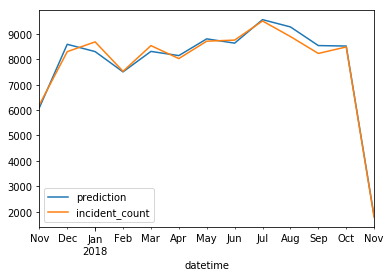

0.4591402250374531
{'memory': None, 'steps': [('preprocessor', Pipeline(steps=[('std_scl', StandardScaler())])), ('regressor', GradientBoostingRegressor(random_state=0))], 'verbose': False, 'preprocessor': Pipeline(steps=[('std_scl', StandardScaler())]), 'regressor': GradientBoostingRegressor(random_state=0), 'preprocessor__memory': None, 'preprocessor__steps': [('std_scl', StandardScaler())], 'preprocessor__verbose': False, 'preprocessor__std_scl': StandardScaler(), 'preprocessor__std_scl__copy': True, 'preprocessor__std_scl__with_mean': True, 'preprocessor__std_scl__with_std': True, 'regressor__alpha': 0.9, 'regressor__ccp_alpha': 0.0, 'regressor__criterion': 'friedman_mse', 'regressor__init': None, 'regressor__learning_rate': 0.1, 'regressor__loss': 'ls', 'regressor__max_depth': 3, 'regressor__max_features': None, 'regressor__max_leaf_nodes': None, 'regressor__min_impurity_decrease': 0.0, 'regressor__min_impurity_split': None, 'regressor__min_samples_leaf': 1, 'regressor__min_sample

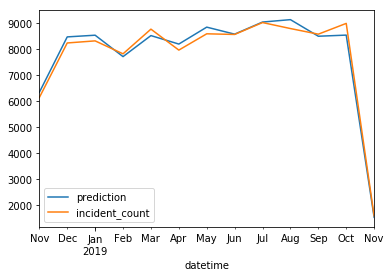

0.3798402747922911
{'memory': None, 'steps': [('preprocessor', Pipeline(steps=[('std_scl', StandardScaler())])), ('regressor', GradientBoostingRegressor(random_state=0))], 'verbose': False, 'preprocessor': Pipeline(steps=[('std_scl', StandardScaler())]), 'regressor': GradientBoostingRegressor(random_state=0), 'preprocessor__memory': None, 'preprocessor__steps': [('std_scl', StandardScaler())], 'preprocessor__verbose': False, 'preprocessor__std_scl': StandardScaler(), 'preprocessor__std_scl__copy': True, 'preprocessor__std_scl__with_mean': True, 'preprocessor__std_scl__with_std': True, 'regressor__alpha': 0.9, 'regressor__ccp_alpha': 0.0, 'regressor__criterion': 'friedman_mse', 'regressor__init': None, 'regressor__learning_rate': 0.1, 'regressor__loss': 'ls', 'regressor__max_depth': 3, 'regressor__max_features': None, 'regressor__max_leaf_nodes': None, 'regressor__min_impurity_decrease': 0.0, 'regressor__min_impurity_split': None, 'regressor__min_samples_leaf': 1, 'regressor__min_sample

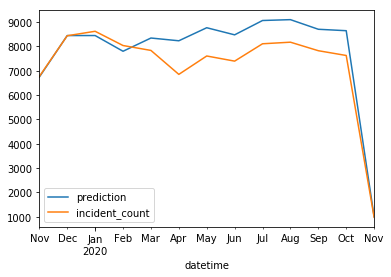

In [50]:
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import init
import model
import importlib

importlib.reload(init)
importlib.reload(prep)
importlib.reload(model)

x, y = init.init()

mod = model.model_ppl()

for tr_ind, te_ind in prep.splitter(n_spi=3).split(x) :
    x_tr, y_tr = x.iloc[tr_ind], y.iloc[tr_ind]
    x_te, y_te = x.iloc[te_ind], y.iloc[te_ind]

    mod.fit(x_tr, y_tr)

    y_pd = mod.predict(x_te)

    print(mod.score(x_te, y_te))
    
    print(mod.get_params())

    print(np.sqrt(mean_squared_error(y_te, y_pd)))

    pd.DataFrame(data=y_pd, index=y_te.index, columns=['prediction']).join(y_te).resample('M').sum().plot()
    plt.show()

In [10]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
# from sklearn.datasets import make_classification
# from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# X, y = make_classification(random_state=0)
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
ppl = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])
# The pipeline can be used as any other estimator
# and avoids leaking the test set into the train set
ppl.fit(x_tr, y_tr)
ppl.score(x_te, y_te)

0.10422374429223745

## Training

In [6]:
from sklearn.model_selection import GridSearchCV



{'memory': None,
 'steps': [('preprocessor', Pipeline(steps=[('std_scl', StandardScaler())])),
  ('regressor', LinearRegression())],
 'verbose': False,
 'preprocessor': Pipeline(steps=[('std_scl', StandardScaler())]),
 'regressor': LinearRegression(),
 'preprocessor__memory': None,
 'preprocessor__steps': [('std_scl', StandardScaler())],
 'preprocessor__verbose': False,
 'preprocessor__std_scl': StandardScaler(),
 'preprocessor__std_scl__copy': True,
 'preprocessor__std_scl__with_mean': True,
 'preprocessor__std_scl__with_std': True,
 'regressor__copy_X': True,
 'regressor__fit_intercept': True,
 'regressor__n_jobs': None,
 'regressor__normalize': False,
 'regressor__positive': False}

## Testing

                           prediction  incident_count
2015-01-01 00:00:00-08:00           7              37
2015-01-01 01:00:00-08:00           7              28
2015-01-01 02:00:00-08:00           7              30
2015-01-01 03:00:00-08:00           7              17
2015-01-01 04:00:00-08:00           7              11
...                               ...             ...
2015-12-31 19:00:00-08:00          13              15
2015-12-31 20:00:00-08:00          13              13
2015-12-31 21:00:00-08:00          10              20
2015-12-31 22:00:00-08:00          10              12
2015-12-31 23:00:00-08:00          10              20

[8760 rows x 2 columns]


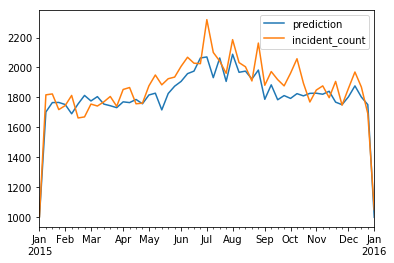

In [11]:
y_pdp = ppl.predict(x_te)
ressp = pd.DataFrame(data=y_pdp, index=y_te.index, columns=['prediction']).join(y_te)
print(ressp)
ressp.resample('W').sum().plot()
plt.show()

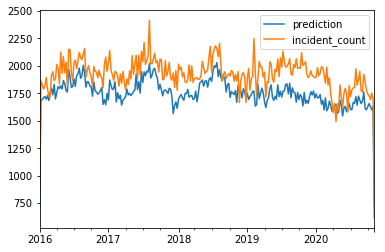

In [12]:
y_pd1p = ppl.predict(x_tr)
pd.DataFrame(data=y_pd1p, index=y_tr.index, columns=['prediction']).join(y_tr).resample('W').sum().plot()
plt.show()